# MRI Example

In the following we will register two brains to learn how to apply torchreg to MRI data.

If you stumble across something weird, have a **look into minimal.ipynb first**. Maybe it's explained there!

In [1]:
import sys
sys.path.append('..')
import torch
import urllib.request
import nibabel as nib
from torchreg import AffineRegistration

In [2]:
def download(url, filepath):
    urllib.request.urlretrieve(url, filepath)

Download two images from OpenNeuro

In [3]:
url_stem = 'https://openneuro.org/crn/datasets/ds003835/snapshots/1.0.0/files'
moving_fpath, static_fpath = 'moving.nii.gz', 'static.nii.gz'
download(f'{url_stem}/sub-10:anat:sub-10_T1w.nii.gz', moving_fpath)
download(f'{url_stem}/sub-20:anat:sub-20_T1w.nii.gz', static_fpath)

Load these .nii-files (called “Nifti”)

In [4]:
moving_nii = nib.load(moving_fpath)
static_nii = nib.load(static_fpath)

Plot using `.orthoview()` to see how misaligned the brains are

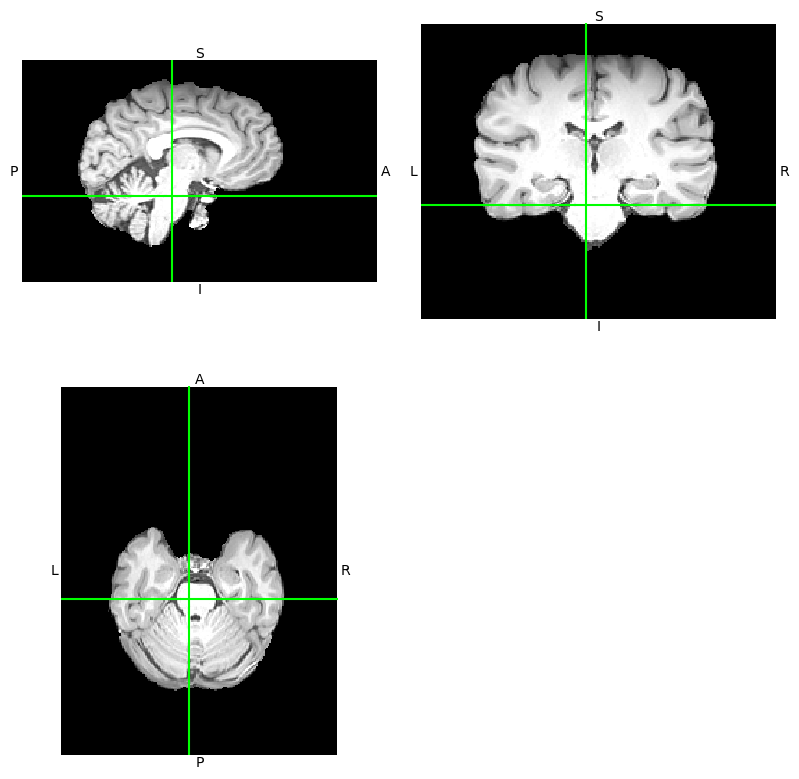

In [5]:
moving_nii.orthoview();

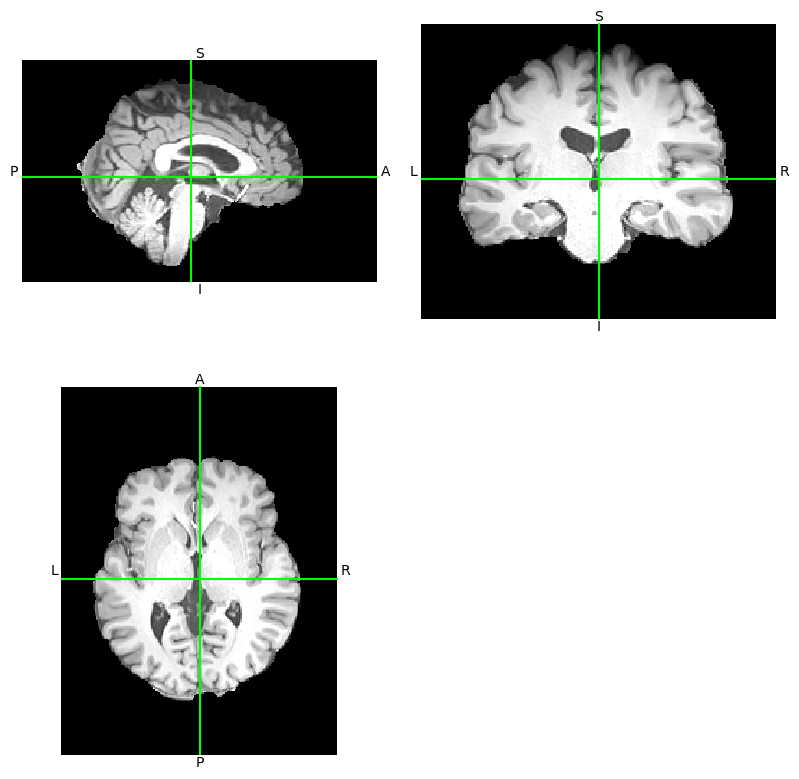

In [6]:
static_nii.orthoview();

The **moving_nii-brain is not as accurately aligned** with the crosshairs **as the static_nii-brain**. We will fix that by **registering `moving_nii` to `static_nii`**!

Convert Niftis into PyTorch tensors

In [7]:
# Get numpy arrays out of niftis
moving = nib.as_closest_canonical(moving_nii).get_fdata()
static = nib.as_closest_canonical(static_nii).get_fdata()
# Convert numpy arrays to torch tensors
moving = torch.from_numpy(moving).float()
static = torch.from_numpy(static).float()

Initialize AffineRegistration

In [8]:
reg = AffineRegistration(is_3d=True)

Registration is sensitive to differences in intensity distributions -> Normalize image intensities such that min = 0 and max = 1

**Warning**: If static and moving MR images stem from different scanners, **direct registration is prone to error**.
Instead, you can use coregistration using brain masks i.e. fit the registration `reg(moving_mask, static_mask)` and then apply the fitted registration `moved = reg.transform(moving)` (see **Coregistration with brainmasks** for more details).
Here, I use direct registration since it is more straightforward to explain/understand!

In [9]:
moving_max = moving.max()
static_max = static.max()

moving_normed = moving / moving_max
static_normed = static / static_max

Run registration using normalized images


In [10]:
moved = reg(moving_normed[None, None], static_normed[None, None])
moved = moved[0, 0]
moved = moving_max * moved  # Undo intensity normalization

Shape: [1, 1, 48, 64, 40]; Dissimiliarity: 0.0019997681956738234: 100%|██████████| 500/500 [00:05<00:00, 94.02it/s] 
Shape: [1, 1, 96, 128, 80]; Dissimiliarity: 0.002297493861988187: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


Convert moved tensor back to Nifti format

In [11]:
moved_nii = nib.Nifti1Image(moved.cpu().numpy(), static_nii.affine)

Plot the moved Nifti to check if it's aligned to static image (compare to plot above!)

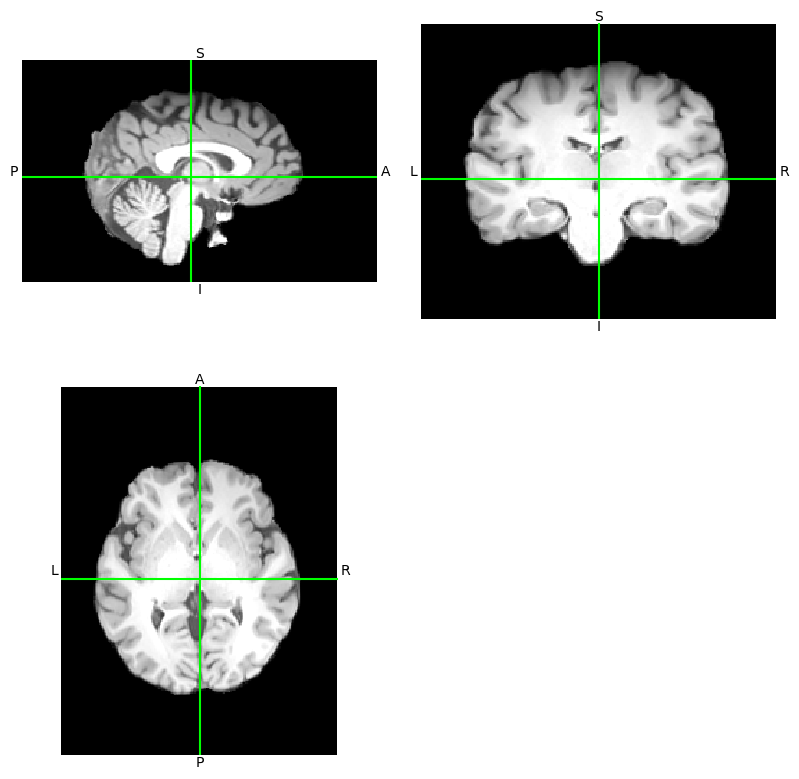

In [12]:
moved_nii.orthoview();

## Run registration with GPU (faster!)
Should run faster with `device = 'cuda'` (or `device = 'mps'` if you run new (>2020) Apple hardware) than with `device = 'cpu'`

In [13]:
device = 'cuda'
# device = 'mps'  # You use a new (>2020) Apple device? Uncomment this line!
reg = AffineRegistration(is_3d=True)
moved = reg(moving_normed[None, None].to(device), static_normed[None, None].to(device))

Shape: [1, 1, 48, 64, 40]; Dissimiliarity: 0.0019997654017060995: 100%|██████████| 500/500 [00:01<00:00, 406.55it/s]
Shape: [1, 1, 96, 128, 80]; Dissimiliarity: 0.0022974968887865543: 100%|██████████| 100/100 [00:00<00:00, 588.44it/s]


## Coregistration with brainmasks
If the MR images stem from different scanners, direct image registration is prone to error.
In that case it is more robust to use brainmasks for fitting the registration and then coregister the image using the fitted registration!

For the Niftis in this example, the brain masks can be easily obtained:

In [14]:
# Get masks (1 if voxel is brain tissue else 0)
moving_mask = (moving > 0).float()
static_mask = (static > 0).float()

Now, we can use these masks to robustly fit the registration

In [15]:
reg = AffineRegistration(is_3d=True)
moved_mask = reg(moving_mask[None, None], static_mask[None, None])

Shape: [1, 1, 48, 64, 40]; Dissimiliarity: 0.011761938221752644: 100%|██████████| 500/500 [00:04<00:00, 106.24it/s]
Shape: [1, 1, 96, 128, 80]; Dissimiliarity: 0.013329630717635155: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


In [16]:
moved = reg.transform(moving[None, None].clone())
moved = moved[0, 0]

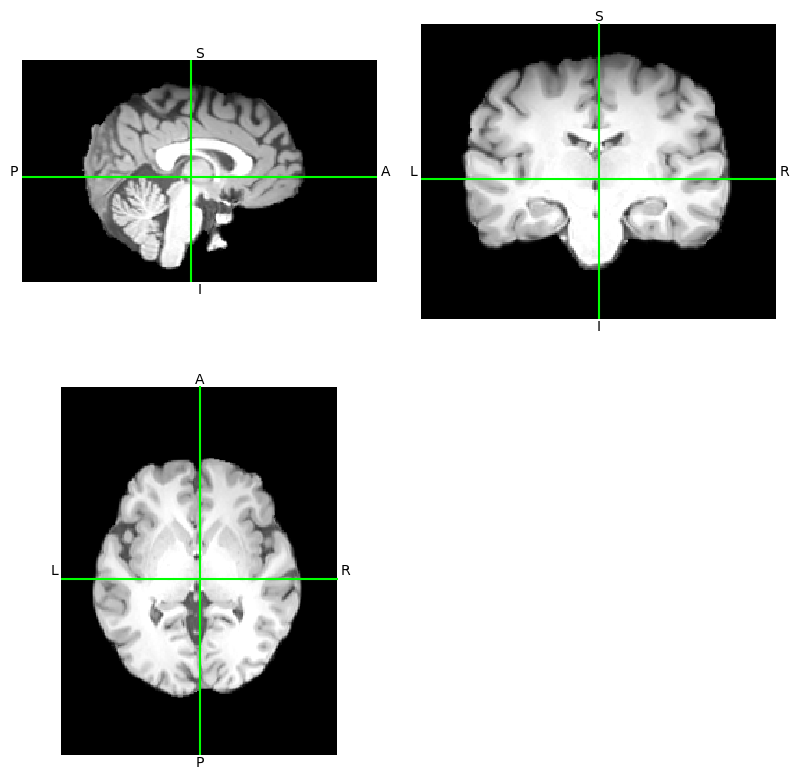

In [17]:
moved_nii = nib.Nifti1Image(moved.cpu().numpy(), static_nii.affine)
moved_nii.orthoview();

## Run registration of multiple images in parallel

First we are artificially creating two moving images by simply shifting the original moving 20 and -20 voxels in the sagittal plane

In [18]:
moving1 = torch.zeros_like(moving)
moving1[20:] = moving[:-20]
moving2 = torch.zeros_like(moving)
moving2[:-10] = moving[10:]

First image shifted to the right

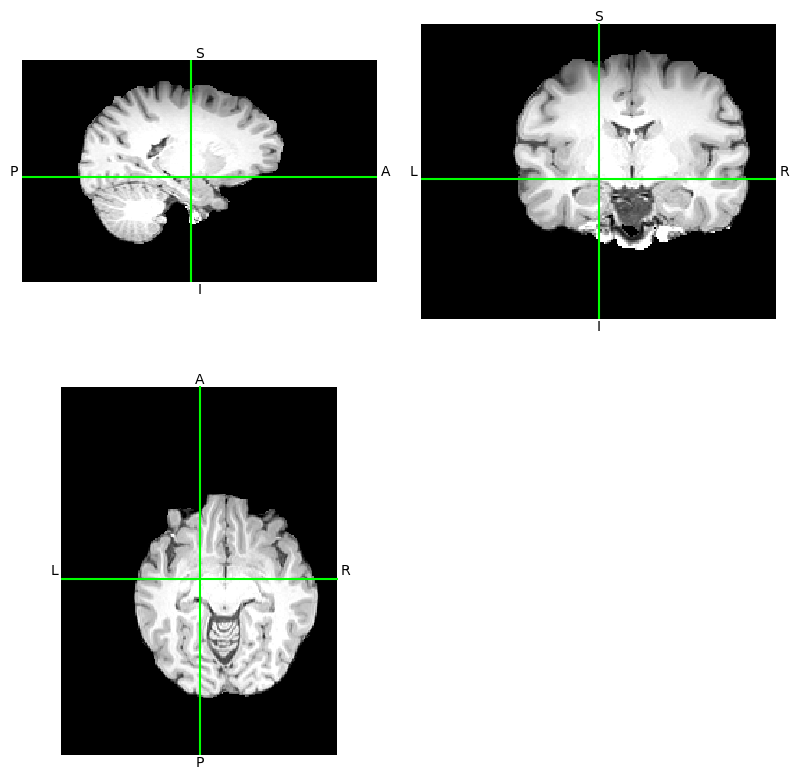

In [19]:
moving1_nii = nib.Nifti1Image(moving1.cpu().numpy(), static_nii.affine)
moving1_nii.orthoview();

Second image shifted to the left

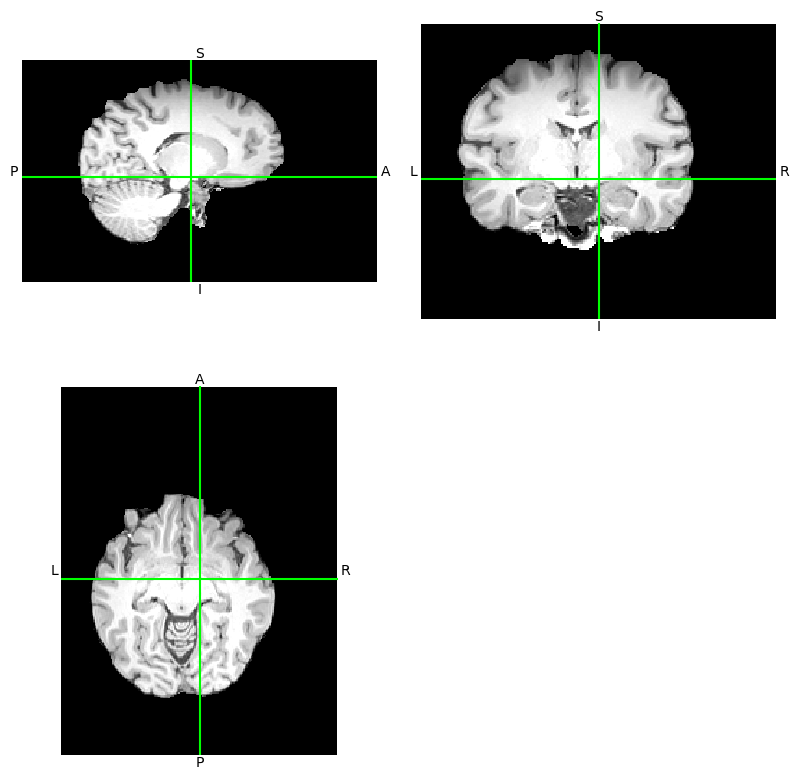

In [20]:
moving2_nii = nib.Nifti1Image(moving2.cpu().numpy(), static_nii.affine)
moving2_nii.orthoview();

As already described in basic.ipynb, it is torch convention for images to have **batch + channel** dimension prior to spatial dimensions x + y (+ z).
This enables you to process multiple images in parallel, simply my concatenating the images along the batch dimension - i.e. the first dimension - using [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [21]:
movings = torch.cat([moving1[None, None], moving2[None, None]], dim=0)
statics = torch.cat([static[None, None], static[None, None]], dim=0)

movings_max, statics_max = movings.max(), statics.max()

reg = AffineRegistration(is_3d=True)
moved = reg(movings / movings_max, statics / statics_max)
moved = movings_max * moved
moved1, moved2 = moved[0, 0], moved[1, 0]
affine = reg.get_affine()
print(affine)

Shape: [2, 1, 48, 64, 40]; Dissimiliarity: 0.002013750607147813: 100%|██████████| 500/500 [00:05<00:00, 93.96it/s]  
Shape: [2, 1, 96, 128, 80]; Dissimiliarity: 0.002298105275258422: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


tensor([[[ 9.4119e-01,  6.2998e-03,  7.3419e-04,  1.2245e-01],
         [ 3.4813e-02,  9.1548e-01, -1.7411e-02, -7.5049e-02],
         [-4.7462e-03,  2.7924e-02,  9.1106e-01,  2.0392e-01]],

        [[ 9.4101e-01,  6.1403e-03,  8.9100e-04,  1.2252e-01],
         [ 3.4972e-02,  9.1511e-01, -1.7892e-02, -7.4947e-02],
         [-4.8976e-03,  2.8358e-02,  9.1144e-01, -1.1046e-01]]])


The affine parameter now contains **two affine matrices** concatenated along the first dimension, corresponding to both images.

And as you can see below, both images were registered just fine!

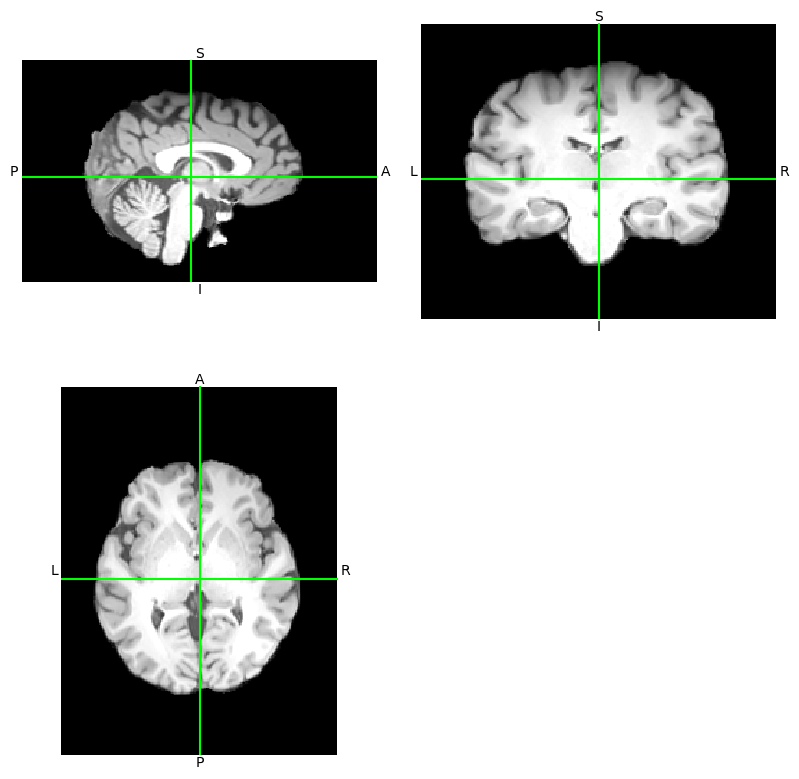

In [22]:
moved1_nii = nib.Nifti1Image(moved1.cpu().numpy(), static_nii.affine)
moved1_nii.orthoview();

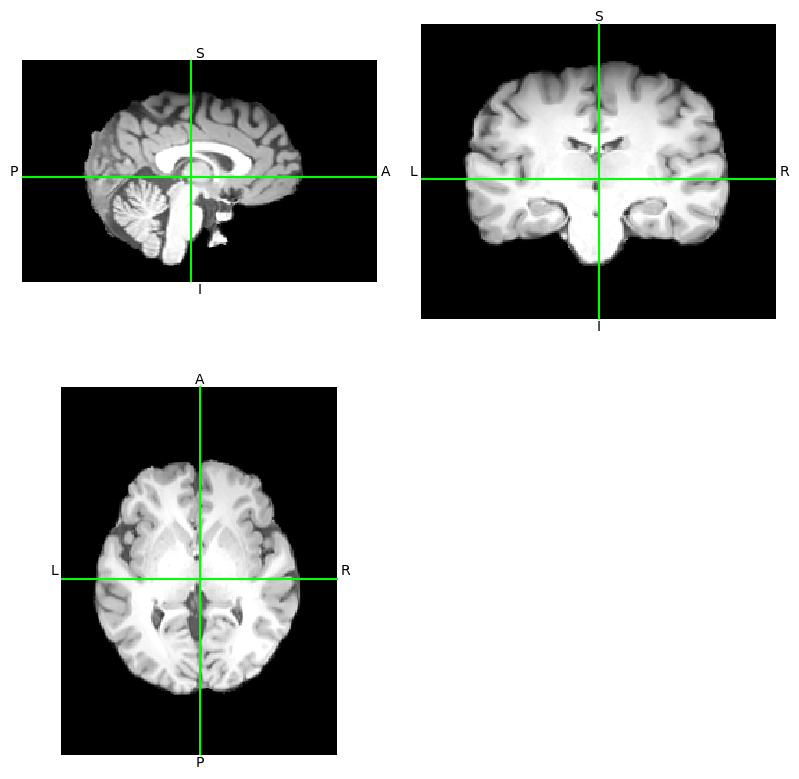

In [23]:
moved2_nii = nib.Nifti1Image(moved2.cpu().numpy(), static_nii.affine)
moved2_nii.orthoview();

## Run registration with multi-modal images

Running multi-modal registration can be achieved almost the same way as running registration in parallel. The only difference is that image concatenation is applied along the channel dimension - i.e. second dimension - instead of the batch dimension - i.e. first dimension.

In [24]:
movings = torch.cat([moving1[None, None], moving2[None, None]], dim=1)
statics = torch.cat([static[None, None], static[None, None]], dim=1)

movings_max, statics_max = movings.max(), statics.max()

reg = AffineRegistration(is_3d=True)
moved = reg(movings / movings_max, statics / statics_max)
moved = movings_max * moved
moved1, moved2 = moved[0, 0], moved[0, 1]
affine = reg.get_affine()
print(affine)

Shape: [1, 2, 48, 64, 40]; Dissimiliarity: 0.004532633349299431: 100%|██████████| 500/500 [00:06<00:00, 76.72it/s] 
Shape: [1, 2, 96, 128, 80]; Dissimiliarity: 0.004944231826812029: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


tensor([[[ 0.9590,  0.0291, -0.0075,  0.1174],
         [ 0.0171,  0.9424, -0.0084, -0.0728],
         [ 0.0097,  0.0134,  1.1271,  0.0455]]])


In contrast to the affine parameter in "Run registration of multiple images in parallel" we end up with only one affine matrix instead of two.
This one affine aligns moving and static with respect to all given modalities.